In [4]:
import os
import torch
from torch.utils.cpp_extension import load_inline
import matplotlib.pyplot as plt

In [5]:
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [6]:
cuda_begin = r'''
#include <torch/extension.h>
#include <iostream>
#include <c10/cuda/CUDAException.h>

#define CHECK_CUDA(x) TORCH_CHECK(x.device().is_cuda(), #x " must be a CUDA tensor")
#define CHECK_CONTIGUOUS(x) TORCH_CHECK(x.is_contiguous(), #x " must be contiguous")
#define CHECK_INPUT(x) CHECK_CUDA(x); CHECK_CONTIGUOUS(x)

inline unsigned int cdiv(unsigned int a, unsigned int b) { return (a + b - 1) / b;}
'''

In [7]:
cuda_src = cuda_begin + '''
__global__ void mandelbrot_kernel(uint8_t *img, uint32_t h, uint32_t w,
                                  float xmin, float xmax, float ymin,
                                  float ymax) {
  uint32_t row = blockDim.y * blockIdx.y + threadIdx.y;
  uint32_t col = blockDim.x * blockIdx.x + threadIdx.x;
  if (row >= h || col >= w)
    return;

  // current pixel
  float cx = xmin + ((float)col / w) * (xmax - xmin);
  float cy = ymin + ((float)row / h) * (ymax - ymin);

  float zx = 0, zy = 0;
  float threshold = 4;
  uint32_t itr = 0, max_itr = 300;

  // z_n+1 = z_n ^ 2 + c
  while (zx * zx + zy * zy <= threshold && itr < max_itr) {
    float zx1 = zx * zx - zy * zy + cx;
    float zy1 = 2 * zx * zy + cy;
    zx = zx1, zy = zy1, ++itr;
  }

  img[row * w + col] = 255 * ((float)itr / max_itr);
}

at::Tensor mandelbrot(uint32_t h, uint32_t w, float xmin, float xmax,
                      float ymin, float ymax) {
  auto options = at::TensorOptions().dtype(at::kByte).device(at::kCUDA);
  at::Tensor img = at::empty({h, w}, options);

  dim3 numThreads(32, 32);
  dim3 numBlocks(cdiv(w, numThreads.x), cdiv(h, numThreads.y));
  mandelbrot_kernel<<<numBlocks, numThreads>>>(img.data_ptr<uint8_t>(), h, w,
                                               xmin, xmax, ymin, ymax);
  return img.cpu();
}
'''

cpp_src = '''
at::Tensor mandelbrot(uint32_t h, uint32_t w, float xmin, float xmax,
                      float ymin, float ymax);
'''

In [8]:
module = load_inline('mandelbrot', cpp_sources=[cpp_src], cuda_sources=[cuda_src], functions=['mandelbrot'], extra_cuda_cflags=['-O2'])

/home/akash/miniconda3/envs/playground/lib/python3.10/site-packages/torch/utils/cpp_extension.py:1964: UserWarning: TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'].
  warnings.warn(


In [41]:
xmin, xmax, ymin, ymax = -2, 1, -1.5, 1.5
h, w = 800, 800
img = module.mandelbrot(h, w, xmin, xmax, ymin, ymax)

Text(0, 0.5, 'Im(c)')

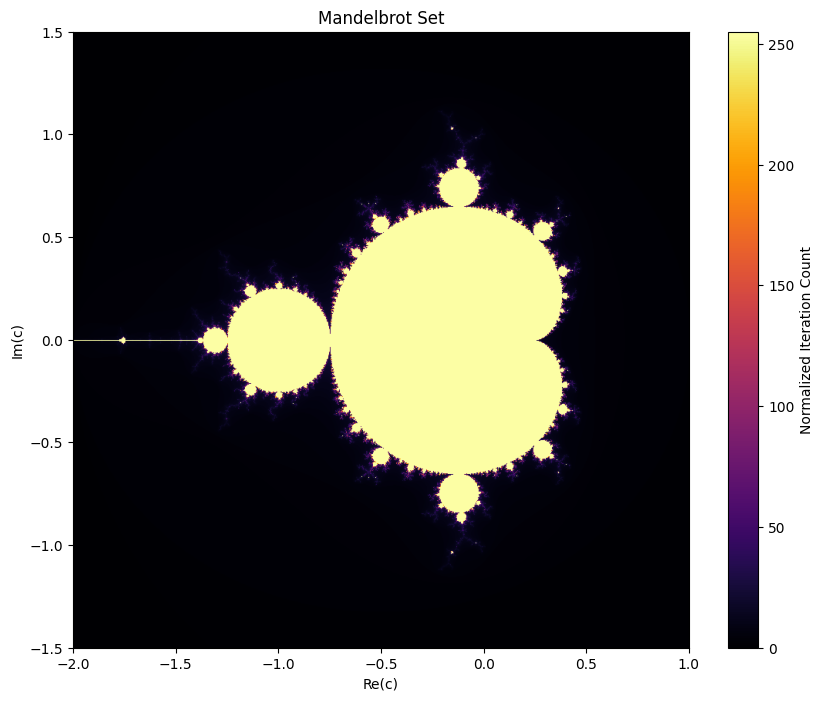

In [44]:
plt.figure(figsize=(10, 8))
plt.imshow(img, cmap='inferno', extent=[xmin, xmax, ymin, ymax])
plt.colorbar(label='Normalized Iteration Count')
plt.title("Mandelbrot Set")
plt.xlabel("Re(c)")
plt.ylabel("Im(c)")